# Time series forecasting

## 1. Librerias y configuraciones previas


In [79]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Preprocesado y modelado
# ==============================================================================

#identificación de outliers
#from sklearn.neighbors import LocalOutlierFactor


#creación de modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


#Evaluar el modelo
from sklearn.metrics import (mean_absolute_error, 
                             r2_score,
                             root_mean_squared_error)
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [80]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot
from utils.funciones2 import identificar_outliers, eval_model, search_param, plot_param_perf

## 3. Carga del dataset

In [81]:
d = pd.read_csv('datasets/05_Metro_Interstate_Traffic_Volume.csv')
d = d.sort_values(by='date_time')
#d = d.sample(10000, random_state=4321)

In [82]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.7+ MB


In [83]:
# Se convierte la variable date_time en el tipo de dato datetime
d['date_time'] = pd.to_datetime(d['date_time'], format='%Y-%m-%d %H:%M:%S')

In [84]:
# Se ordena el dataFrame por 'date_time'
d = d.sort_values(by='date_time')

In [85]:
# Se convierte la temperatura de °K a °C
d["temp"] = d["temp"] - 273.15

In [86]:
d.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,15.1300,0.0000,0.0000,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,16.2100,0.0000,0.0000,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,16.4300,0.0000,0.0000,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,16.9800,0.0000,0.0000,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,17.9900,0.0000,0.0000,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,18.5700,0.0000,0.0000,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,20.0200,0.0000,0.0000,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,20.7100,0.0000,0.0000,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,20.9900,0.0000,0.0000,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,19.9500,0.0000,0.0000,20,Clouds,few clouds,2012-10-02 18:00:00,4770


## 4. Visualización de datos

### Variables de entrada

In [87]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,holiday,weather_main,weather_description
0,None,Clouds,scattered clouds
1,None,Clouds,broken clouds


In [88]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float32','int32','int64']).columns.tolist()
d[numCols].head(2)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,15.1300,0.0000,0.0000,40,5545
1,16.2100,0.0000,0.0000,75,4516


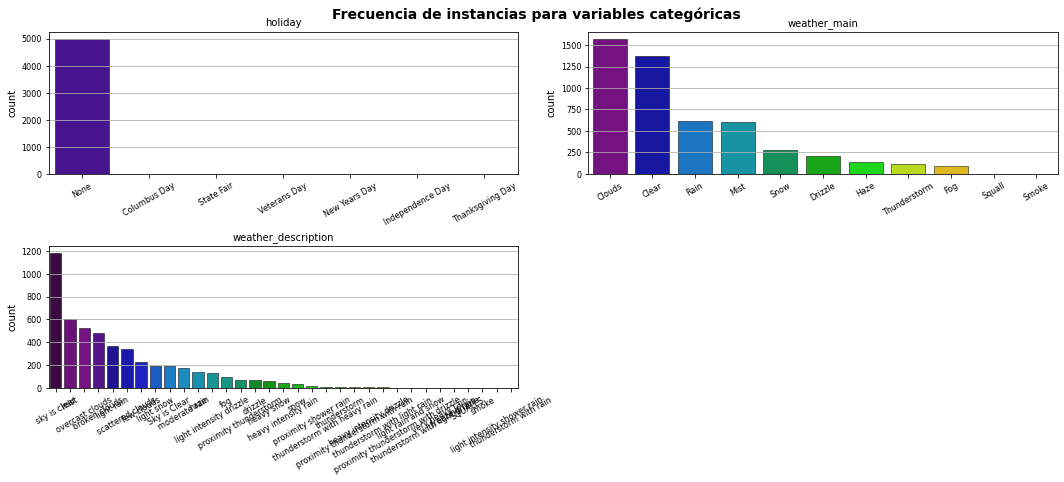

In [89]:
## Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, d.sample(5000) , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

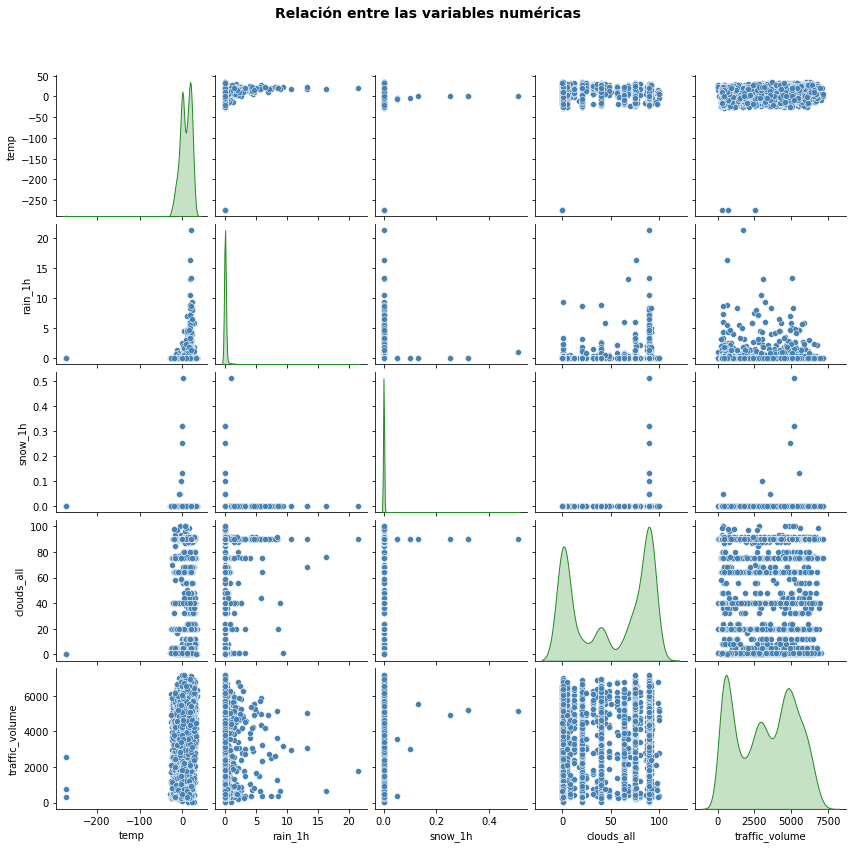

In [90]:
multiple_plot(1, d.sample(5000) , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [91]:
#Variable datetime

print(f"Fecha inicial: {d['date_time'].min()}")
print(f"Fecha final  : {d['date_time'].max()}")

Fecha inicial: 2012-10-02 09:00:00
Fecha final  : 2018-09-30 23:00:00


In [92]:
# Se agrega una variable year_month para efectos de la visualización
d['year_month'] = d['date_time'].dt.to_period('M')

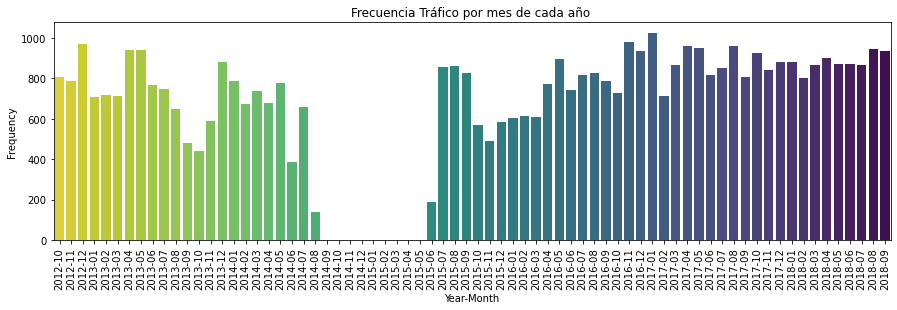

In [93]:
# Visualizar las frecuencias por mes de cada año

# Se cuenta la cantidad de registros por mes
freqCont = d['year_month'].value_counts().sort_index()

# Se crea un rango completo de meses desde el primer hasta el último mes en los datos
all_months = pd.period_range(start=freqCont.index.min(), end=freqCont.index.max(), freq='M')

# se reindexa la serie de frecuencias para incluir todos los meses, llenando los meses faltantes con cero
freqCont = freqCont.reindex(all_months, fill_value=0)

# Se convierte la serie a un DataFrame para usar con seaborn
freq_df = freqCont.reset_index()
freq_df.columns = ['Year-Month', 'Frequency']

# Se crea la gráfica de frecuencias por mes de cada año usando seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x='Year-Month', y='Frequency', data=freq_df, palette='viridis_r')

plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Frecuencia Tráfico por mes de cada año ')
plt.xticks(rotation=90)

plt.show()

### Variable de salida

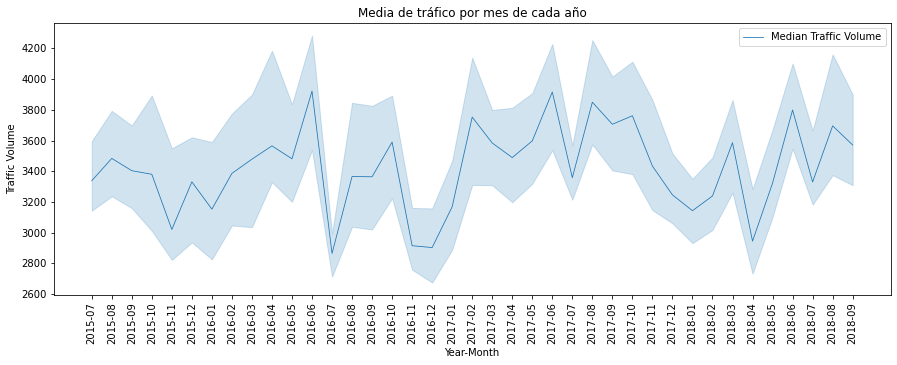

In [94]:
#Creación de la gráfica de mediana de tráfico por mes de cada año

start_date = '2015-07'
end_date = '2018-09'


#Filtrar los datos de acuerdo con start_date y end_date
df_filtered = d[(d['year_month'] >= start_date) & (d['year_month'] <= end_date)]


plt.figure(figsize=(15, 5)) 

sns.lineplot(
    x=df_filtered['year_month'].astype(str),  
    y=df_filtered['traffic_volume'],
    estimator=np.median,
    #color="blue",
    linewidth=0.8,
    label='Median Traffic Volume'  # label para para la leyenda
)

plt.xlabel('Year-Month')
plt.ylabel('Traffic Volume')
plt.title('Media de tráfico por mes de cada año')  
plt.xticks(rotation=90)

plt.legend()
plt.show()

## 5. Preparación de datos

### Creación de variables a partir de las existentes

In [95]:
df_features = df_filtered.copy()

In [96]:
# Creación de nuevas variables a partir de la variable 'date_time'

df_features["day_of_week"] = df_features["date_time"].dt.dayofweek #Lunes = 0, Martes = 1, etc.
df_features["weekend"]     = df_features["day_of_week"] > 4 
df_features["weekend"]     = df_features["weekend"].astype(int)
df_features["hour"]        = df_features["date_time"].dt.hour
df_features["month"]       = df_features["date_time"].dt.month
df_features["day"]         = df_features["date_time"].dt.day
df_features["year"]        = df_features["date_time"].dt.year

In [97]:
# Convertir 'holiday' a binario

# Reemplazar los valores con la cadena 'None' en None
df_features["holiday"] = df_features["holiday"].fillna('None')

df_features["holiday"] = df_features["holiday"].apply(lambda x: 0 if x == 'None' else 1)

In [98]:
# Se encuentran las categorías que contienen el 99% de los datos para la variable: 'weather_main'


# Cuenta la frecuencia relativa acumulada de cada valor de la variable 'weather_main' 
# aquellos de menos mayores de 99% seran marcados como False (el resto se marcará como True)
weather_list = d["weather_main"].value_counts(normalize=True).cumsum() <= 0.99


# Filtrar las categorías con pocas frecuencias (aquellas que quedaron en False)
low_freq_categories = weather_list[weather_list == False].index


# Crear el diccionario con las categorías de baja frecuencia
weather_dict = {category: "other" for category in low_freq_categories}


# Reemplazar los 'weather_main' con pocas ocurrencias ('Fog', 'Smoke', 'Squall') a una clase 'other'
df_features["weather_main"] = df_features["weather_main"].replace(weather_dict)


In [99]:
# Dummificación de 'weather_main'

df_features = pd.concat(
    [
        df_features,
        pd.get_dummies(df_features["weather_main"], drop_first=True, dtype=int),
    ],
    axis=1,
)

In [100]:
# Eliminación de características que no se van a utilizar

df_features = df_features.drop(
    columns=["weather_description", "weather_main", "rain_1h", "snow_1h", 'year_month']
)

In [101]:
# Convierte todos los nombres de las columnas del DataFrame df_features a minúsculas

df_features.columns = [col.lower() for col in df_features.columns]

In [102]:
#Eliminar las variables de la lista catCols

catCols = [col for col in catCols if col not in ["weather_description", "weather_main"]]

In [103]:
#Eliminar las variables de la lista numCols

numCols = [col for col in numCols if col not in ["rain_1h", "snow_1h"]]

### Duplicados

In [104]:
# Eliminación de duplicados
print(f"Filas antes de eliminar duplicados: {len(df_features)}")

df_features = df_features.drop_duplicates()
print(f"Filas después de eliminar duplicados: {len(df_features)}")

#Reiniciar el indice
d.reset_index(drop=True, inplace=True) 

Filas antes de eliminar duplicados: 32047
Filas después de eliminar duplicados: 32030


### Outliers

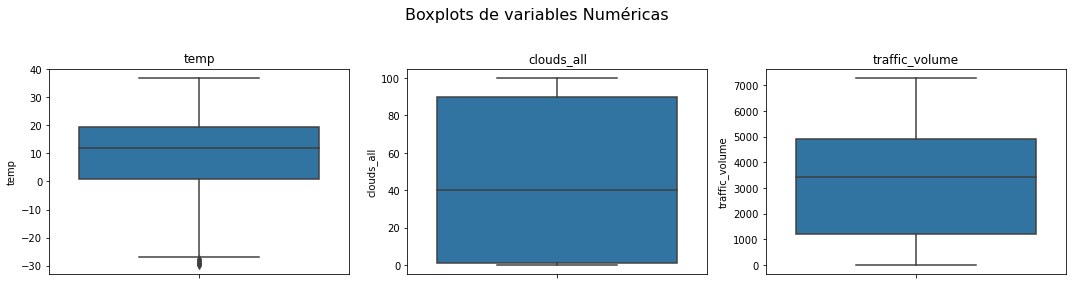

In [105]:
##Visualización de valores outliers para las variables categóricas

# Crear una figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Crear un gráfico de boxplot para cada variable en su subplot correspondiente
for ax, col in zip(axes, numCols):
    sns.boxplot(y=df_features[col], ax=ax)
    ax.set_title(f'{col}')

# Agregar un título a la figura completa
fig.suptitle('Boxplots de variables Numéricas', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [106]:
outliers_indices = identificar_outliers(df_features, numCols)
print("outliers:", outliers_indices)

outliers: [29248, 29249, 29250, 29251, 29252]


In [107]:
df_features.loc[outliers_indices].head(2)

,holiday,temp,clouds_all,date_time,traffic_volume,day_of_week,weekend,hour,month,day,year,clouds,drizzle,haze,mist,rain,snow,thunderstorm,other
29248,0,-27.5300,1,2016-12-18 04:00:00,277,6,1,4,12,18,2016,0,0,0,0,0,0,0,0
29249,0,-28.2600,1,2016-12-18 05:00:00,459,6,1,5,12,18,2016,0,0,0,0,0,0,0,0


In [108]:
# Eliminar los valores atípicos del dataframe original
df_features = df_features.drop(outliers_indices)

## Análisis de variables

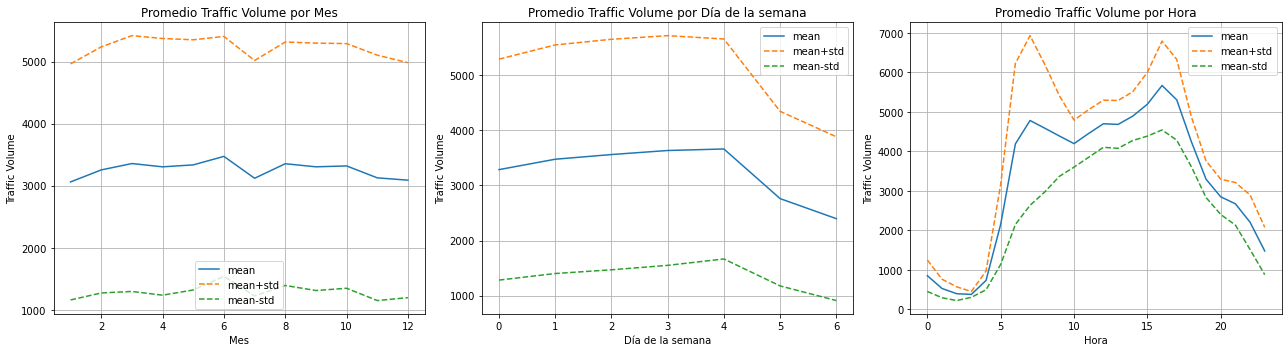

In [109]:
# Análisis de comportamiento del tráfico por mes, día y hora

# Lista de agrupaciones y títulos
groupings = [("month", "Mes"), ("day_of_week", "Día de la semana"), ("hour", "Hora")]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Iterar sobre las agrupaciones y crear gráficos
for i, (group, label) in enumerate(groupings):
    stats = df_features.groupby(group, as_index=False)["traffic_volume"].agg(["mean", "std"]).reset_index()
    axes[i].plot(stats[group], stats["mean"], label="mean")
    axes[i].plot(stats[group], stats["mean"] + stats["std"], label="mean+std", linestyle='--')
    axes[i].plot(stats[group], stats["mean"] - stats["std"], label="mean-std", linestyle='--')
    axes[i].set_title(f"Promedio Traffic Volume por {label}")
    axes[i].set_xlabel(label)
    axes[i].set_ylabel("Traffic Volume")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

['weekend', 'clouds', 'drizzle', 'haze', 'mist', 'rain', 'snow', 'thunderstorm', 'other']


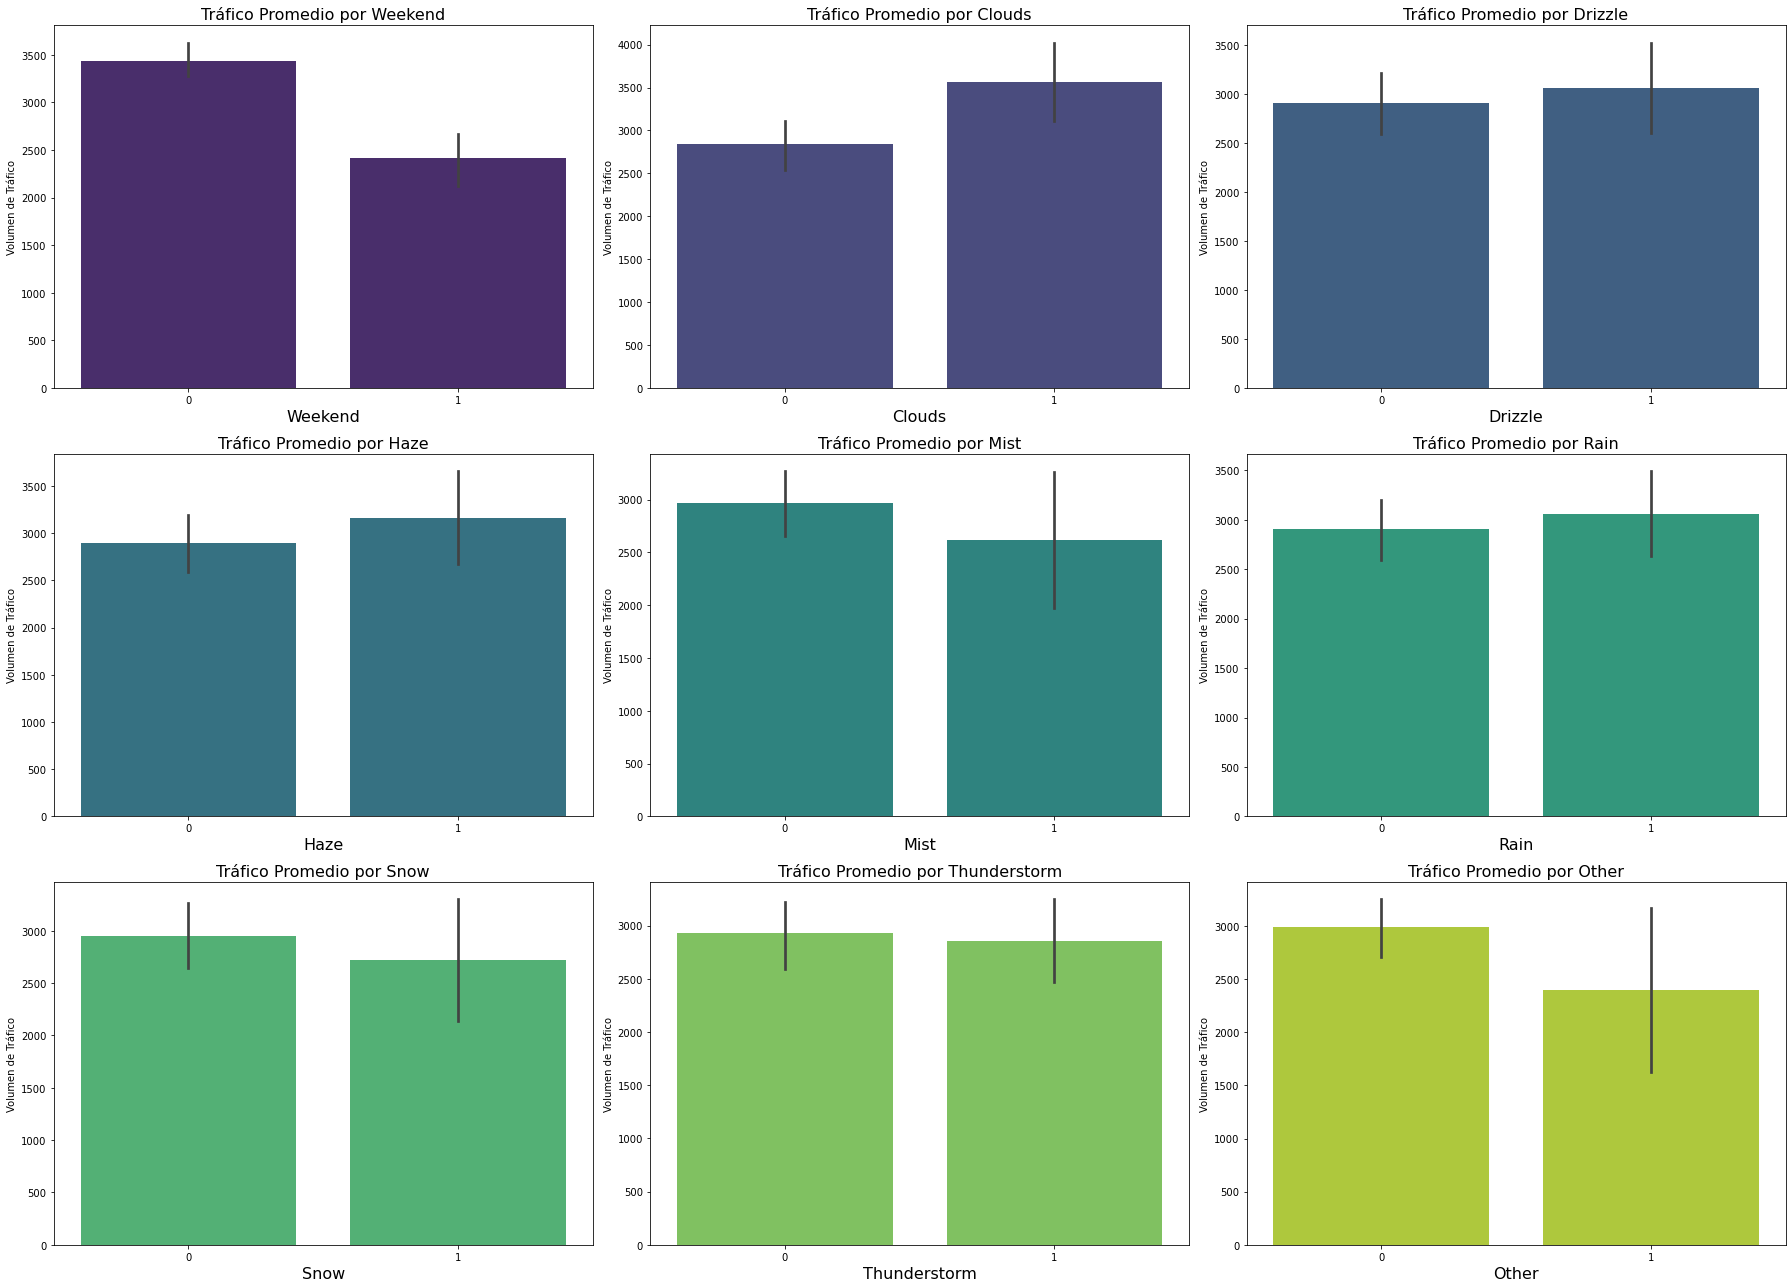

In [110]:
# Lista de variables 

variables = df_features.select_dtypes(include = ['int32']).columns.tolist()
#variables = ['clouds', 'drizzle', 'haze', 'mist', 'rain', 'snow', 'thunderstorm', 'other', 'weekend']
print(variables)

# Generar una lista de colores
colors = sns.color_palette("viridis", len(variables))

# Calcular el volumen promedio de tráfico para cada variable
traffic_means = df_features.groupby(variables).traffic_volume.mean().reset_index()

# Crear una figura con subplots
fig, axes = plt.subplots(3, 3, figsize=(25, 18))

# Iterar sobre las variables y crear gráficos de barras
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    sns.barplot(data=traffic_means, x=var, y="traffic_volume", ax=axes[row, col], color=colors[i])
    
    axes[row, col].set_title(f"Tráfico Promedio por {var.capitalize()}",fontsize=16)
    axes[row, col].set_xlabel(var.capitalize(), fontsize=16)
    axes[row, col].set_ylabel("Volumen de Tráfico")

plt.tight_layout()
plt.show()

## Train Test Split y Escalamiento de Variables

In [115]:
# se extrae una muestra 
df_features_sample = df_features.sample(500, random_state=123)

# Se definen las fechas de corte para los filtros de la gráfica
cutoff_year_upper = 2017
cutoff_month_upper = 7

# Crear una máscara para los datos de entrenamiento y prueba y aplicar los filtros
train_mask = ((df_features["year"] < cutoff_year_upper) | 
              ((df_features["year"] == cutoff_year_upper) & (df_features["month"] <= cutoff_month_upper)))

test_mask = (df_features["year"] > cutoff_year_upper) | \
            ((df_features["year"] == cutoff_year_upper) & (df_features["month"] > cutoff_month_upper))

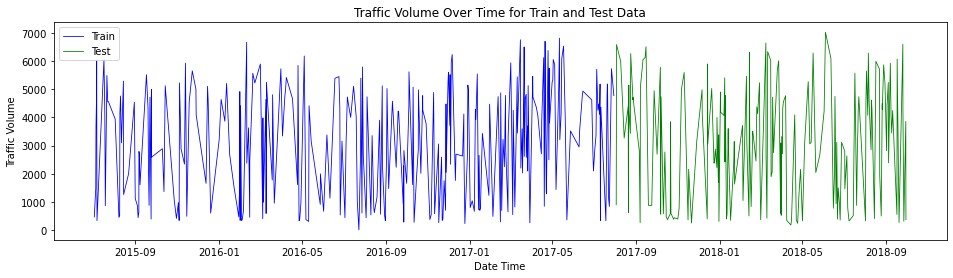

In [116]:
# Crear la gráfica de líneas
plt.figure(figsize=(16, 4))  

# Graficar datos de entrenamiento
sns.lineplot(
    x=df_features_sample[train_mask]['date_time'],
    y=df_features_sample[train_mask]['traffic_volume'],
    color="blue",
    label="Train",
    linewidth=0.8
)

# Graficar datos de prueba
sns.lineplot(
    x=df_features_sample[test_mask]['date_time'],
    y=df_features_sample[test_mask]['traffic_volume'],
    color="green",
    label="Test",
    linewidth=0.8
)

plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time for Train and Test Data')
plt.legend()
plt.show()

In [35]:
df_features = df_features.drop(columns=["date_time"])
numCols.remove("traffic_volume")

In [36]:
#Datos de prueba
dfPrueba = df_features[test_mask].sample(frac=0.1, random_state=123)

In [37]:
# Separación de variables de entrada y variable de salida
X = df_features.drop(columns=["traffic_volume"])
y = df_features["traffic_volume"]

# Crear máscaras para excluir los registros de Xp
exclude_mask = ~df_features.index.isin(dfPrueba.index)

# Filtrar X y y para excluir los registros de Xp
X_filtered = X[exclude_mask]
y_filtered = y[exclude_mask]

# Crear conjuntos de entrenamiento y prueba
X_train = X_filtered[train_mask]
X_test = X_filtered[test_mask]
y_train = y_filtered[train_mask]
y_test = y_filtered[test_mask]

In [38]:
#Escalar Variables númericas (todas)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Escalado de datos
scaler = MinMaxScaler()

# Escalado de datos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [39]:
X_train.head(2)

,holiday,temp,clouds_all,day_of_week,weekend,hour,month,day,year,clouds,drizzle,haze,mist,rain,snow,thunderstorm,other
0,0.0000,0.7015,0.0100,0.3333,0.0000,0.0000,0.5455,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.7048,0.0100,0.3333,0.0000,0.0435,0.5455,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## 6. Creación de modelos

### Regresión Lineal

In [40]:
# Se crea el modelo de Regresión lineal
lr = LinearRegression()

# Se entrena el modelo
lr.fit(X_train, y_train)

LinearRegression()

In [41]:
# Evaluación del modelo

lr_model_train_metrics = eval_model(lr, X_train, y_train)
lr_model_train_metrics["name"] = type(lr).__name__ 

lr_model_test_metrics = eval_model(lr, X_test, y_test)
lr_model_test_metrics["name"] = type(lr).__name__

print(lr_model_train_metrics)
print(lr_model_test_metrics)

{'mae': 1542.98923, 'rmse': 1765.9388, 'r2': 0.19396, 'mase': 2.91721, 'name': 'LinearRegression'}
{'mae': 1558.99249, 'rmse': 1779.82326, 'r2': 0.1983, 'mase': 2.92442, 'name': 'LinearRegression'}


### Decision Tree Regressor

In [42]:
# Se crea el modelo de Árbol de decisión
dtr = DecisionTreeRegressor(random_state=1234, max_depth=5)

# Se entrena el modelo
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=1234)

In [43]:
# Evaluación del modelo

dtr_model_train_metrics = eval_model(dtr, X_train, y_train)
dtr_model_train_metrics["name"] = type(dtr).__name__ 

dtr_model_test_metrics = eval_model(dtr, X_test, y_test)
dtr_model_test_metrics["name"] = type(dtr).__name__

print(dtr_model_train_metrics)
print(dtr_model_test_metrics)

{'mae': 385.69391, 'rmse': 595.0625, 'r2': 0.90848, 'mase': 0.7292, 'name': 'DecisionTreeRegressor'}
{'mae': 401.87113, 'rmse': 620.0436, 'r2': 0.9027, 'mase': 0.75385, 'name': 'DecisionTreeRegressor'}


### Random Forest Regressor

In [44]:
# Se crea el modelo de random Forest
rfr = RandomForestRegressor(random_state=1234, bootstrap=True, max_depth=5)

# Se entrena el modelo
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=1234)

In [45]:
# Evaluación del modelo

rfr_model_train_metrics = eval_model(rfr, X_train, y_train)
rfr_model_train_metrics["name"] = type(rfr).__name__ 

rfr_model_test_metrics = eval_model(rfr, X_test, y_test)
rfr_model_test_metrics["name"] = type(rfr).__name__

print(rfr_model_train_metrics)
print(rfr_model_test_metrics)

{'mae': 380.88364, 'rmse': 591.41947, 'r2': 0.90959, 'mase': 0.72011, 'name': 'RandomForestRegressor'}
{'mae': 399.32111, 'rmse': 618.67739, 'r2': 0.90313, 'mase': 0.74906, 'name': 'RandomForestRegressor'}


## 7. Evaluación de modelos

In [46]:
# Creación de dataframes para comparar resultados entre los modelos

# dataframe de métricas de train (ordenadas por mase)
df_compare_train = pd.DataFrame(
    [
        lr_model_train_metrics,
        dtr_model_train_metrics,
        rfr_model_train_metrics,
    ]
).sort_values(by="mase", ascending=True)

# dataframe de métricas de test (ordenadas por mase)
df_compare_test = pd.DataFrame(
    [
        lr_model_test_metrics,
        dtr_model_test_metrics,
        rfr_model_test_metrics,
    ]
).sort_values(by="mase", ascending=True)

In [47]:
# Se crea un dataframe a partir de df_compare_train y df_compare_test
df_combined_inner = pd.merge(df_compare_train, df_compare_test, on='name', suffixes=('_train', '_test'))

# Definir el orden deseado de las columnas
colOrd = ['name','mae_train', 'mae_test', 'rmse_train', 'rmse_test', 'r2_train', 'r2_test', 'mase_train', 'mase_test']

# Reordenar las columnas
df_combined_inner = df_combined_inner[colOrd]

df_combined_inner[colOrd].sort_values(by="mae_train", ascending=True)

,name,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test,mase_train,mase_test
0,RandomForestRegressor,380.8836,399.3211,591.4195,618.6774,0.9096,0.9031,0.7201,0.7491
1,DecisionTreeRegressor,385.6939,401.8711,595.0625,620.0436,0.9085,0.9027,0.7292,0.7539
2,LinearRegression,1542.9892,1558.9925,1765.9388,1779.8233,0.1940,0.1983,2.9172,2.9244


### Ajuste de parámetros al mejor modelo

In [48]:
# Definir rangos de búsqueda para cada parámetro
rfr_search_ranges = {
    "n_estimators": np.arange(20, 100, 20),
    "max_depth": np.arange(2, 16, 2),
    "max_features": np.arange(2, 16, 2),
}

# Definir parámetros base del modelo
rfr_base_params = {"random_state": 4321, "bootstrap": True, "max_depth": 5}

Ajustando para n_estimators=20
Ajustando para n_estimators=40
Ajustando para n_estimators=60
Ajustando para n_estimators=80


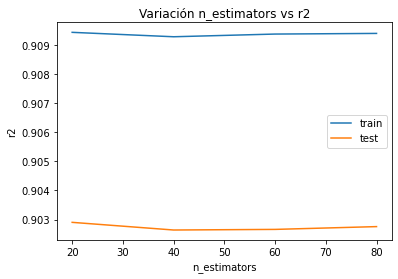

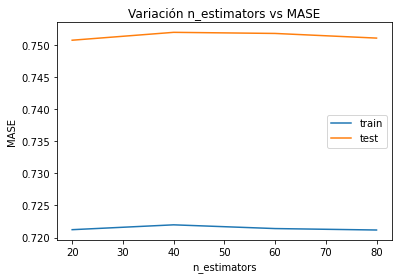

--------------------------------------------------

Ajustando para max_depth=2
Ajustando para max_depth=4
Ajustando para max_depth=6
Ajustando para max_depth=8
Ajustando para max_depth=10
Ajustando para max_depth=12
Ajustando para max_depth=14


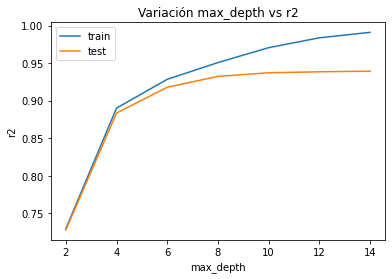

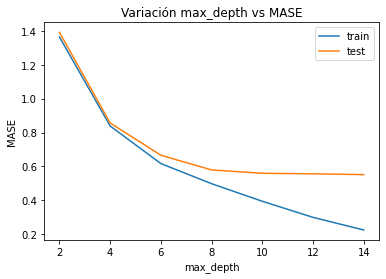

--------------------------------------------------

Ajustando para max_features=2
Ajustando para max_features=4
Ajustando para max_features=6
Ajustando para max_features=8
Ajustando para max_features=10
Ajustando para max_features=12
Ajustando para max_features=14


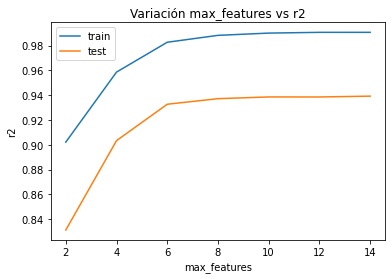

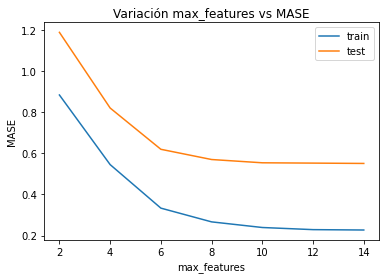

--------------------------------------------------



In [49]:
# Búsqueda de parámetros
for param, search_range in rfr_search_ranges.items():
    r2_scores_rfr, mase_scores_rfr = search_param(
        RandomForestRegressor(),
        X_train,
        y_train,
        X_test,
        y_test,
        rfr_base_params,
        param,
        search_range,
    )
    plot_param_perf(
        search_range, r2_scores_rfr, f"Variación {param} vs r2", param, "r2"
    )
    plot_param_perf(
        search_range, mase_scores_rfr, f"Variación {param} vs MASE", param, "MASE"
    )
    print("-" * 50 + "\n")

In [50]:
# Definición de búsqueda de parámetros
hyper_params = {
    "n_estimators": [10, 20, 30],
    "max_depth": [5, 6, 7],
    "max_features": [7, 8, 9],
}
# Inicialización del objeto del modelo
rfr = RandomForestRegressor(**rfr_base_params)


# TimeSeriesSplit respeta el orden temporal de los datos, permite evitar 
# el "look-ahead bias" (usar información futura para predecir el pasado).
tscv = TimeSeriesSplit(
                        n_splits=5, # Número de divisiones (splits) a realizar en los datos
                        gap=24)     # Los registros estan dados en horas, entonces se omiten 24 observaciones (1 dia)
                                    # entre el conjunto de entrenamiento y el conjunto de prueba. Permite asegurarse 
                                    # que los datos utilizados para entrenar un modelo de series temporales no incluyan 
                                    # información futura que podría influir en los resultados del modelo. 
                                    # Esto es crucial para mantener la integridad y la validez de los pronósticos

# Grid Search
grid_search_rfr = GridSearchCV(
    estimator=rfr,
    param_grid=hyper_params,
    cv=tscv,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)
grid_search_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(max_depth=14, max_features=14,
                                             n_estimators=80,
                                             random_state=4321),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7], 'max_features': [7, 8, 9],
                         'n_estimators': [10, 20, 30]},
             scoring='r2', verbose=1)

In [51]:
resultados = pd.DataFrame(grid_search_rfr.cv_results_)
resultados.filter(regex="(param.*|mean_t|std_t|mean_f)").drop(
    columns="params"
).sort_values(["mean_test_score", "mean_fit_time"], ascending=False).head(5)

,mean_fit_time,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score
26,1.6090,7,9,30,0.9031,0.0227
25,1.1937,7,9,20,0.9023,0.0216
24,0.4829,7,9,10,0.9010,0.0255
23,1.5284,7,8,30,0.8983,0.0220
22,1.1572,7,8,20,0.8976,0.0225


In [52]:
# Resultados promedio de r2 score en cada pliegue del mejor estimador
pd.DataFrame(grid_search_rfr.cv_results_).filter(regex="split.*_test_score").loc[
    grid_search_rfr.best_index_
]

split0_test_score   0.8744
split1_test_score   0.8809
split2_test_score   0.9121
split3_test_score   0.9118
split4_test_score   0.9364
Name: 26, dtype: float64

In [53]:
# Escoger el mejor Random Forest
best_rfr = grid_search_rfr.best_estimator_

best_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, max_features=9, n_estimators=30,
                      random_state=4321)

In [59]:
# Evaluación en datos de entrenamiento
y_train_pred = best_rfr.predict(X_train)
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(
    f"Train MASE: {mean_absolute_scaled_error(y_train, y_train_pred, y_train=y_train):.4f} \n"
)


# Evaluación en datos de prueba
    #No estacional: y_train=y_test
    #Estacional: y_train=y_train[:-period]
    
y_test_pred = best_rfr.predict(X_test)
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}")
print(
    f"Test MASE: {mean_absolute_scaled_error(y_test, y_test_pred, y_train=y_test):.4f}" 
)

Train R2: 0.9266
Train MASE: 0.6724 

Test R2: 0.9110
Test MASE: 0.7250


### Selección entre los Mejores  Modelos

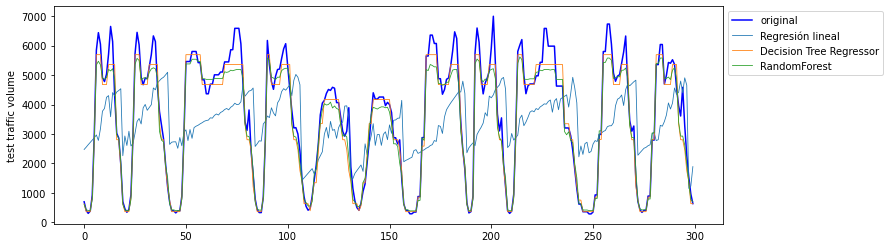

In [60]:
# Rangos de registros a visualizar
start =0
end = 300

# Resultados en los datos de prueba para los mejores modelos
predictions = {
    "Regresión lineal": lr.predict(X_test),
    "Decision Tree Regressor": dtr.predict(X_test),
    "RandomForest": best_rfr.predict(X_test)
}

# Crear DataFrame para la comparación de los modelos
ts_df = pd.DataFrame({"test traffic volume": y_test.values})
ts_df = ts_df.assign(**{f"predicted traffic volume {name}": pred for name, pred in predictions.items()})


# Función para graficar un rango de tiempo específico
#def plot_time_range(ts_df, start, end):
plt.figure(figsize=(12, 4))  # Ajusta el tamaño de la figura

# Graficar una ventana de tiempo de los datos de prueba junto con los resultados de los mejores modelos
sns.lineplot(data=ts_df["test traffic volume"][start:end], color="blue", label="original")

for name in predictions.keys():
    sns.lineplot(data=ts_df[f"predicted traffic volume {name}"][start:end], label=name, linewidth=0.8)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Dataset de Prueba

In [61]:
# Separación de variables de entrada y variable de salida
Xp = dfPrueba.drop(columns=["traffic_volume"])
yp = dfPrueba["traffic_volume"]

In [62]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Escalado de datos
Xp_scaled = scaler.transform(Xp)

## Convertir a dataframes
Xp_scaled = pd.DataFrame(Xp_scaled, columns=Xp.columns)

In [63]:
Xp_scaled.head(2)

,holiday,temp,clouds_all,day_of_week,weekend,hour,month,day,year,clouds,drizzle,haze,mist,rain,snow,thunderstorm,other
0,0.0000,0.7491,0.0100,0.3333,0.0000,0.0870,0.4545,0.1667,1.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.6817,0.0100,0.6667,0.0000,0.2609,0.6364,0.5667,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


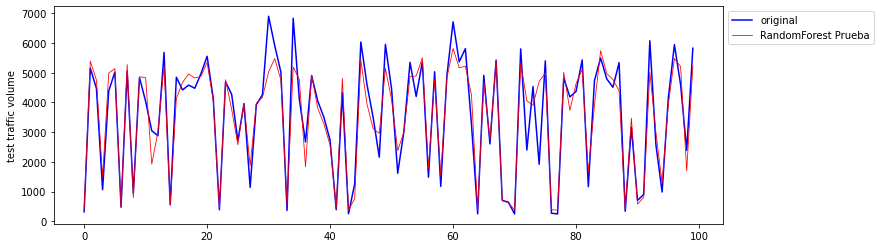

In [75]:
# Rangos de registros a visualizar
start =0
end = 100

# Resultados en los datos de prueba para el mejor modelo
predictions = {
    "RandomForest Prueba": best_rfr.predict(Xp_scaled)
}

# Crear DataFrame para la comparación de los modelos
ts_df = pd.DataFrame({"test traffic volume": yp.values})
ts_df = ts_df.assign(**{f"predicted traffic volume {name}": pred for name, pred in predictions.items()})


# Función para graficar un rango de tiempo específico
#def plot_time_range(ts_df, start, end):
plt.figure(figsize=(12, 4))  # Ajusta el tamaño de la figura

# Graficar una ventana de tiempo de los datos de prueba junto con los resultados de los mejores modelos
sns.lineplot(data=ts_df["test traffic volume"][start:end], color="blue", label="original")

for name in predictions.keys():
    sns.lineplot(data=ts_df[f"predicted traffic volume {name}"][start:end], label=name, color="red", linewidth=0.8)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [76]:
# Evaluación en datos de entrenamiento
y_train_pred = best_rfr.predict(X_train)
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(
    f"Train MASE: {mean_absolute_scaled_error(y_train, y_train_pred, y_train=y_train):.4f} \n"
)

# Evaluación en datos de prueba
y_pred_rfr = best_rfr.predict(Xp_scaled)
print(f"Prueba R2: {r2_score(yp, y_pred_rfr):.4f}")
print(
    f"Prueba MASE: {mean_absolute_scaled_error(yp, y_pred_rfr, y_train=yp):.4f}"
)

Train R2: 0.9266
Train MASE: 0.6724 

Prueba R2: 0.9034
Prueba MASE: 0.1749


In [66]:
dfPrueba

,holiday,temp,clouds_all,traffic_volume,day_of_week,weekend,hour,month,day,year,clouds,drizzle,haze,mist,rain,snow,thunderstorm,other
44717,0,18.9400,1,318,2,0,2,6,6,2018,0,0,0,0,0,0,0,0
36383,0,14.8500,1,5156,4,0,6,8,18,2017,0,0,0,1,0,0,0,0
41266,0,-14.7400,75,4470,0,0,11,2,5,2018,1,0,0,0,0,0,0,0
42506,0,-3.2100,1,1062,1,0,23,3,20,2018,0,0,0,0,0,0,0,0
42290,0,3.8500,1,4388,0,0,18,3,12,2018,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39356,0,3.6900,1,5862,3,0,6,11,30,2017,0,0,0,0,0,0,0,0
47160,0,16.4500,90,4624,1,0,10,8,28,2018,0,0,0,0,1,0,0,0
37534,0,11.2800,40,6062,3,0,6,9,28,2017,0,0,0,0,1,0,0,0
40388,0,-25.5300,5,2487,5,1,8,1,6,2018,0,0,1,0,0,0,0,0


In [67]:
# Convertir la lista de predicciones a un DataFrame
df_predicciones = pd.DataFrame(best_rfr.predict(Xp_scaled), columns=['predicted_traffic_volume'], index=dfPrueba.index)

# Unir dfPrueba con df_predicciones
df_resultado = pd.concat([dfPrueba, df_predicciones], axis=1)
df_resultado.head(2)

,holiday,temp,clouds_all,traffic_volume,day_of_week,weekend,hour,month,day,year,clouds,drizzle,haze,mist,rain,snow,thunderstorm,other,predicted_traffic_volume
44717,0,18.9400,1,318,2,0,2,6,6,2018,0,0,0,0,0,0,0,0,401.0655
36383,0,14.8500,1,5156,4,0,6,8,18,2017,0,0,0,1,0,0,0,0,5392.7051


In [68]:
# Agregar una columna de error con la diferencia entre el valor real y el pronosticado
df_resultado['error'] = df_resultado['traffic_volume'] - df_resultado['predicted_traffic_volume']

df_resultado[['traffic_volume', 'predicted_traffic_volume', 'error']].sort_values(by='error', ascending=False)[450:550]

,traffic_volume,predicted_traffic_volume,error
45842,1991,1826.0168,164.9832
45275,2362,2197.0708,164.9292
46552,801,636.6537,164.3463
41125,5021,4857.5726,163.4274
45759,4958,4795.5480,162.4520
...,...,...,...
40253,2041,1949.4053,91.5947
37114,2995,2906.0477,88.9523
42801,4400,4311.1899,88.8101
37048,4135,4049.6136,85.3864


In [69]:
# Calcular el error absoluto
df_resultado['absolute_error'] = df_resultado['error'].abs()

# Calcular el error promedio del valor absoluto
error_promedio_absoluto = df_resultado['absolute_error'].mean()

# Calcular la mediana del valor absoluto del error
mediana_error_absoluto = df_resultado['absolute_error'].median()

print(f"Error promedio absoluto   : {error_promedio_absoluto}")
print(f"Mediana del error absoluto: {mediana_error_absoluto}")

Error promedio absoluto   : 408.60008325389276
Mediana del error absoluto: 271.4861989213388


In [70]:
df_resultado[['traffic_volume', 'predicted_traffic_volume','absolute_error']] \
    .sort_values(by='absolute_error', ascending=True)

,traffic_volume,predicted_traffic_volume,absolute_error
44871,2947,2946.5978,0.4022
41243,3735,3734.3251,0.6749
44570,5008,5008.8005,0.8005
41508,2775,2776.2803,1.2803
40385,694,696.1770,2.1770
...,...,...,...
45559,1920,4703.8835,2783.8835
43262,1478,4264.3648,2786.3648
39514,2160,5121.3765,2961.3765
47349,1995,5241.7982,3246.7982


#### Referencias


- Random Forest
    - https://cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast-espa%C3%B1ol.html
    - https://cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn
    - https://www.youtube.com/watch?v=_0J-a1IQjjQ
    